# EDA

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from sklearn.linear_model import LinearRegression
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('classic')
%matplotlib inline

## Data Description

The data was taken from the Yelp Dataset Challenge in which Yelp aimed to offer students the chance to explore and analyze their data. From this data, we were given 5 json files which contained information about yelp users and their reviews for different business. We are only looking at the restaurants within those business and the users that rated them.

The data was separated into five different JSON files from yelp (business.json, review.json, user.json, checkin.json, and tip.json.)  The review and user files are extremely large, so we decided to only read-in random samples of entries from each dataset stored in lists: sample_rvw and sample_usr. After doing this, we read in 237142 distinct users with 615653 distinct reviews.

We did not find any abnormalities in the data types for each variable, and we did not find any null values. The data was fairly clean.

**Business.json** holds dictionaries that describe location data, attributes and categories for each business. Such attributes include the business rating, takeout offerings, parking accommodations, and hours of operation. Initially, the dataset holds information about businesses outside of the restaurant industry, so we filtered it down to include only data for restaurants.

**Review.json** includes dictionaries for each review given by a user for a certain business. The dictionary includes text data for the actual review and a rating out of 5 stars. It also includes information about the business and votes given by other users on the usefulness, funniness, or “coolness” of the review.

**User.json** includes dictionaries about each user’s profile.  Profile data includes how many compliments a user may have received and the type of compliments received for their reviews. It also includes their name, information about their yelp membership and an array of their friends.

**Checkin.json** includes a dictionary for each time a user “checked in” or stated they were present at a business. Thus, there are vast amounts of entries.

**Tips.json** includes dictionaries for each tip a user gives. A tip is a shorter type of review that includes the user id, business id, the tip text, and likes from different users for that tip.

## Data Exploration

In [15]:
# get reviews of restaurants within desired categories
def get_desired_restaurants(df, category_list):
    desired_rows = []

    for row in df.iterrows():
        for cat in category_list:
            # get row if it is in the correct category
            if cat in row[1]['categories']:
                desired_rows.append(row[1])

    df_desired = pd.DataFrame(desired_rows)

    # drop duplicates from multiple categories
    df_desired = df_desired[df_desired['review_id'].duplicated() == False]
    return(df_desired)           

In [3]:
# to get all reviews within a certain time period - input string in YYYY format (ex: '2015')
def get_data_yearly(df, year):
    return df[df['date'].dt.strftime('%Y') == year]

In [4]:
def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecesasry plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()
        
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)

Because the data was so large, we reconciled by taking random samples of the review and users data so that it wazs more manageable. To unify the data from the separate JSON files, a random sample of reviews and users are read in and matched together on a unique user ID.  Then, these observations are matched to business data on a unique business ID.  Finally, these are matched with the variable containing total amount of check-ins on the business being reviewed.  The data is then pared down to contain only restaurants.  These steps leave us with a resulting dataframe in which each row represents a unique restaurant review and has numerous column variables with user, review, and business data describing the observation.  

For now, we decided to exclude tips.json from our EDA and analysis because we believe the data found in tips will offer no new information that cannot be found already in user reviews. Tips are quick suggestions or comments on restaurants that users can give in the form of likes and shorts texts.

In [44]:
df_biz = pd.read_json('/Users/alliwiggins/Documents/cs109a/dataset/business.json', lines = True)
df_check = pd.read_json('/Users/alliwiggins/Documents/cs109a/dataset/checkin.json', lines = True)

df_review_samp = pd.read_json('/Users/alliwiggins/Documents/cs109a/dataset/sample_review.json', lines = True)
df_usr_samp = pd.read_json('/Users/alliwiggins/Documents/cs109a/dataset/sample_user.json', lines = True)


In [47]:
df_biz.head()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state
0,691 Richmond Rd,"{'RestaurantsPriceRange2': 2, 'BusinessParking...",YDf95gJZaq05wvo7hTQbbQ,"[Shopping, Shopping Centers]",Richmond Heights,"{'Monday': '10:00-21:00', 'Tuesday': '10:00-21...",1,41.541716,-81.493116,Richmond Town Square,,44143,17,2.0,OH
1,2824 Milton Rd,"{'GoodForMeal': {'dessert': False, 'latenight'...",mLwM-h2YhXl2NCgdS84_Bw,"[Food, Soul Food, Convenience Stores, Restaura...",Charlotte,"{'Monday': '10:00-22:00', 'Tuesday': '10:00-22...",0,35.236870,-80.741976,South Florida Style Chicken & Ribs,Eastland,28215,4,4.5,NC
2,337 Danforth Avenue,"{'BusinessParking': {'garage': False, 'street'...",v2WhjAB3PIBA8J8VxG3wEg,"[Food, Coffee & Tea]",Toronto,"{'Monday': '10:00-19:00', 'Tuesday': '10:00-19...",0,43.677126,-79.353285,The Tea Emporium,Riverdale,M4K 1N7,7,4.5,ON
3,"7702 E Doubletree Ranch Rd, Ste 300",{},CVtCbSB1zUcUWg-9TNGTuQ,"[Professional Services, Matchmakers]",Scottsdale,"{'Friday': '9:00-17:00', 'Tuesday': '9:00-17:0...",1,33.565082,-111.916400,TRUmatch,,85258,3,3.0,AZ
4,4719 N 20Th St,"{'RestaurantsTableService': False, 'GoodForMea...",duHFBe87uNSXImQmvBh87Q,"[Sandwiches, Restaurants]",Phoenix,{},0,33.505928,-112.038847,Blimpie,,85016,10,4.5,AZ


In [48]:
df_check.head()

,business_id,time
0,7KPBkxAOEtb3QeIL9PEErg,"{'Thursday': {'21:00': 4, '1:00': 1, '4:00': 1..."
1,kREVIrSBbtqBhIYkTccQUg,"{'Monday': {'13:00': 1}, 'Thursday': {'20:00':..."
2,tJRDll5yqpZwehenzE2cSg,"{'Monday': {'12:00': 1, '1:00': 1}, 'Saturday'..."
3,nhZ1HGWD8lMErdn3FuWuTQ,"{'Sunday': {'18:00': 1, '17:00': 2, '22:00': 1..."
4,vDoXZGE7p6xAkKQ0XQPvoA,"{'Thursday': {'15:00': 1}, 'Saturday': {'23:00..."


In [49]:
df_review_samp.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,uYHaNptLzDLoV_JZ_MuzUA,0,2015-07-27,0,6JF4WfHgwYrrdZ2VeYtnFw,3,"Stayed here for two nights, costs was £109 per...",1,Q-3YCVywc03w56wYtGlKvg
1,jQsNFOzDpxPmOurSWCg1vQ,0,2011-08-10,0,GiEB_A-m9HuX521WQNbL8w,4,1st! Place is not closed. There was an issue w...,1,UG4EKu13JRwzRix6ESINdg
2,jQsNFOzDpxPmOurSWCg1vQ,0,2012-10-08,0,ai6O4UqqDqnjO7gfz6jBkA,3,1st visit had the lo mein...delish! \n2nd vis...,0,R6vb0FtmClhfwajs_AuusQ
3,jQsNFOzDpxPmOurSWCg1vQ,6,2015-02-12,5,sb7iYaCc6ggpShtElkcwiw,3,My wife wanted to try this place for awhile no...,7,6jz_Yr6_AP2WWLbj9gGDpA
4,jQsNFOzDpxPmOurSWCg1vQ,0,2009-01-24,0,j51qEbi4hMm6WHGlkt57xg,2,"Haven't eaten at this location in particular, ...",1,UXZDRVdx8eJqdqb13Bcfcg


In [50]:
df_usr_samp.head()

,average_stars,compliment_cool,compliment_cute,compliment_funny,compliment_hot,compliment_list,compliment_more,compliment_note,compliment_photos,compliment_plain,compliment_profile,compliment_writer,cool,elite,fans,friends,funny,name,review_count,useful,user_id,yelping_since
0,4.06,4,0,4,5,0,5,4,5,5,1,22,1,"[2016, 2015]",5,"[Puvuej6lzJ1JOEmtjG7V_Q, fq7CL1myWPYeH0d4bKtsI...",3,Erica,68,5,YHJIMK_zVH_VY6HCY6bYvg,2012-06-08
1,3.91,7,0,7,1,0,1,8,2,17,0,5,45,"[2016, 2017, 2015]",6,"[ZRHPR_mj9A1p6guJ4myTow, DDF6lbrU8TJRS4BtsKkdA...",21,Andreas,375,41,gGdg9LOh61iUX1ui6suS0w,2013-11-25
2,4.07,4,0,4,3,0,1,1,0,1,0,1,14,[],4,"[ZAkeWdyAQy37YYb59NCgcg, Cxu5vpkpUWIv0-oEH4lV7...",3,Ember,24,41,NUEQYD6T-ixWejImJYlDHQ,2013-01-20
3,4.27,3,0,3,0,0,1,6,2,5,0,2,75,"[2016, 2017, 2015, 2014]",13,"[Z_0TuoNCeE1xVGZ3peYzwQ, aSCTF9U9nE1yFfQM85mWO...",80,Robert,233,343,r5aSkafqboBd4L6v8_1Pow,2012-02-02
4,4.15,6,0,6,2,0,0,5,1,4,0,2,7,[],2,"[tgPjX5MplSOXubcTqvCNtw, 6wRnnHSKO05sJ8SALkY8w...",3,Colleen,32,19,s8bVHRqx6cI8F8HGf3A_og,2014-12-18


In [6]:
print("The total number of users read in is: ", df_usr_samp.shape[0])
print("The total number of reviews read in is: ", df_review_samp.shape[0])

The total number of users read in is:  236535
The total number of reviews read in is:  616040


In [7]:
# get users that are represented in the review sample
df_usr_subset = df_usr_samp[df_usr_samp['user_id'].isin(df_review_samp['user_id'])]

# pare reviews down to those which have user data
df_rvw_subset = df_review_samp[df_review_samp['user_id'].isin(df_usr_subset['user_id'])]

# now we have two dataframes, each with same users, one has user data and the other has review data

# get business and check data corresponding to what reviews we have in the sample
df_biz_subset = df_biz[df_biz['business_id'].isin(df_rvw_subset['business_id'])]
df_check_subset = df_check[df_check['business_id'].isin(df_biz_subset['business_id'])]

In [8]:
# 64301 unique businesses out of 1880087 total reviews (average 3 reviews for every restaurant)
print("The total number of unique recorded businesses in this sample is: ", len(df_rvw_subset['business_id'].unique()))
print("The total number of unique recorded users in this sample is: ", len(df_usr_subset['user_id'].unique()))
print("The total number of recorded reviews in this sample is: ", df_rvw_subset.shape[0])

The total number of unique recorded businesses in this sample is:  50696
The total number of unique recorded users in this sample is:  67101
The total number of recorded reviews in this sample is:  123080


In [ ]:
# explain pairing of final dataset

In [9]:
# this dataframe contains every review, paired with the user who gave the review and the business that was reviewed
df_rvw_usr = df_usr_subset.merge(df_rvw_subset, on = 'user_id', how = 'left')

# this dataframe contains every review, user giving the review, and characteristics of business being reviewed
# each row represents a review
df_rvw_usr_biz = df_rvw_usr.merge(df_biz_subset, on = 'business_id', how = 'left')

# add in total checkin data for each restaurant (measure of popularity)
dict_checkins = {}

for index, row in df_check_subset.iterrows():
    for key in row['time'].keys(): 
        dict_checkins[row['business_id']] = np.sum(list(row['time'][key].values()))

checkin_series = pd.Series(dict_checkins, name = 'total_checkins')
df_check_merger = pd.DataFrame(checkin_series).reset_index()
df_check_merger.columns = ['business_id', 'total_checkins']

# this df contains all user, review, biz, and checkin data
df_all = df_rvw_usr_biz.merge(df_check_merger, on = 'business_id', how = 'left')

# there is not checkin data for some businesses - choosing to fill those with zeroes
df_all.fillna(0, inplace = True)

# confirmation that every original review in the subset is contained in this dataframe
print(df_all.shape[0] == df_rvw_subset.shape[0])

True


In [10]:
# dropping predictors

# drop latitude, longitude, neighborhood - too specific for predictors (stick with state,city as location identifiers)
# we're tracking names by user ids and restaurant ids, so we can drop names
# drop neighborhood since most entries don't have values

df_all.drop(['name_x', 'name_y', 'latitude', 'longitude', 'neighborhood'], axis = 1, inplace = True)

# rename columns to remove user, review, business ambiguity (some colnames were the same)
df_all.columns = ['average_stars_usr', 'compliment_cool', 'compliment_cute',
       'compliment_funny', 'compliment_hot', 'compliment_list',
       'compliment_more', 'compliment_note', 'compliment_photos',
       'compliment_plain', 'compliment_profile', 'compliment_writer', 'cool_usr',
       'elite', 'fans', 'friends', 'funny_usr', 'review_count_usr', 'useful_usr',
       'user_id', 'yelping_since', 'business_id', 'cool_rvw', 'date', 'funny_rvw',
       'review_id', 'stars_rvw', 'text', 'useful_rvw', 'address', 'attributes',
       'categories', 'city', 'hours', 'is_open', 'postal_code',
       'review_count_biz', 'stars_biz', 'state', 'total_checkins']

In [11]:
df_all.head()

,average_stars_usr,compliment_cool,compliment_cute,compliment_funny,compliment_hot,compliment_list,compliment_more,compliment_note,compliment_photos,compliment_plain,compliment_profile,compliment_writer,cool_usr,elite,fans,friends,funny_usr,review_count_usr,useful_usr,user_id,yelping_since,business_id,cool_rvw,date,funny_rvw,review_id,stars_rvw,text,useful_rvw,address,attributes,categories,city,hours,is_open,postal_code,review_count_biz,stars_biz,state,total_checkins
0,3.91,7,0,7,1,0,1,8,2,17,0,5,45,"[2016, 2017, 2015]",6,"[ZRHPR_mj9A1p6guJ4myTow, DDF6lbrU8TJRS4BtsKkdA...",21,375,41,gGdg9LOh61iUX1ui6suS0w,2013-11-25,z71CwRHhAuiHoSnUz7IIRQ,0,2016-06-08,0,P5FSUlIx7EY2fOF21llRnw,4,wirklich großes baufachgeschäft. hier endlich ...,0,Augsburger Str. 500,{},"[Hardware Stores, Home Services, Building Supp...",Stuttgart,"{'Monday': '8:00-20:00', 'Tuesday': '8:00-20:0...",1,70327,3,4.0,BW,2.0
1,3.91,7,0,7,1,0,1,8,2,17,0,5,45,"[2016, 2017, 2015]",6,"[ZRHPR_mj9A1p6guJ4myTow, DDF6lbrU8TJRS4BtsKkdA...",21,375,41,gGdg9LOh61iUX1ui6suS0w,2013-11-25,3h4ECb0-RTL9_OeYHafMwA,0,2014-03-14,0,F_OtJbA1Ka1zb71CqUWt_g,5,"auch von mir 5 sterne. ja, hier ist wirklich a...",0,Daimlerstr. 104,"{'GoodForMeal': {'dessert': False, 'latenight'...","[Food, Fast Food, Restaurants]",Stuttgart,"{'Monday': '9:00-18:00', 'Tuesday': '9:00-18:0...",1,70372,6,5.0,BW,0.0
2,3.91,7,0,7,1,0,1,8,2,17,0,5,45,"[2016, 2017, 2015]",6,"[ZRHPR_mj9A1p6guJ4myTow, DDF6lbrU8TJRS4BtsKkdA...",21,375,41,gGdg9LOh61iUX1ui6suS0w,2013-11-25,xVmR_J2FjrGNOrWn_y2QKg,1,2015-04-17,0,ZWjCil702YKFzQEZSY-_TA,3,eigentlich mag ich solche großen brauhäuser mi...,1,Bolzstr. 10,"{'RestaurantsTableService': True, 'GoodForMeal...","[Breweries, Restaurants, Beer Hall, Gastropubs...",Stuttgart,"{'Monday': '11:00-0:00', 'Tuesday': '11:00-0:0...",1,70173,79,3.5,BW,12.0
3,3.91,7,0,7,1,0,1,8,2,17,0,5,45,"[2016, 2017, 2015]",6,"[ZRHPR_mj9A1p6guJ4myTow, DDF6lbrU8TJRS4BtsKkdA...",21,375,41,gGdg9LOh61iUX1ui6suS0w,2013-11-25,XVk7W6EuiLVSjpIg2npvUw,0,2016-12-23,0,NMATy5SPYoW7f5h1DOMFKg,3,naja. man wird satt. aber viel mehr darf man n...,0,Felgergasse 7,{'NoiseLevel': 'loud'},"[Restaurants, Food, German, Breweries]",Stuttgart,"{'Monday': '11:30-23:00', 'Tuesday': '11:30-23...",1,70372,6,4.0,BW,2.0
4,3.91,7,0,7,1,0,1,8,2,17,0,5,45,"[2016, 2017, 2015]",6,"[ZRHPR_mj9A1p6guJ4myTow, DDF6lbrU8TJRS4BtsKkdA...",21,375,41,gGdg9LOh61iUX1ui6suS0w,2013-11-25,DVxOGucZ3NpIeTtbk1ZpAg,0,2014-01-12,0,MtPSN7mL5wnliC-CAwYzOA,3,leider immer mehr leerstände. strauss hat nun ...,0,Wildunger Str. 2 - 4,"{'RestaurantsPriceRange2': 2, 'BusinessParking...","[Bistros, Shopping, Shopping Centers, Fast Foo...",Stuttgart,"{'Monday': '9:30-20:00', 'Tuesday': '9:30-20:0...",1,70372,15,3.5,BW,14.0


In [51]:
# get subset of this dataframe that contains only restaurants/food stores
df_rest_all = get_desired_restaurants(df_all, ['Food', 'Restaurants'])
df_rest_all.head()


,average_stars_usr,compliment_cool,compliment_cute,compliment_funny,compliment_hot,compliment_list,compliment_more,compliment_note,compliment_photos,compliment_plain,compliment_profile,compliment_writer,cool_usr,elite,fans,friends,funny_usr,review_count_usr,useful_usr,user_id,yelping_since,business_id,cool_rvw,date,funny_rvw,review_id,stars_rvw,text,useful_rvw,address,attributes,categories,city,hours,is_open,postal_code,review_count_biz,stars_biz,state,total_checkins
1,3.91,7,0,7,1,0,1,8,2,17,0,5,45,"[2016, 2017, 2015]",6,"[ZRHPR_mj9A1p6guJ4myTow, DDF6lbrU8TJRS4BtsKkdA...",21,375,41,gGdg9LOh61iUX1ui6suS0w,2013-11-25,3h4ECb0-RTL9_OeYHafMwA,0,2014-03-14,0,F_OtJbA1Ka1zb71CqUWt_g,5,"auch von mir 5 sterne. ja, hier ist wirklich a...",0,Daimlerstr. 104,"{'GoodForMeal': {'dessert': False, 'latenight'...","[Food, Fast Food, Restaurants]",Stuttgart,"{'Monday': '9:00-18:00', 'Tuesday': '9:00-18:0...",1,70372,6,5.0,BW,0.0
2,3.91,7,0,7,1,0,1,8,2,17,0,5,45,"[2016, 2017, 2015]",6,"[ZRHPR_mj9A1p6guJ4myTow, DDF6lbrU8TJRS4BtsKkdA...",21,375,41,gGdg9LOh61iUX1ui6suS0w,2013-11-25,xVmR_J2FjrGNOrWn_y2QKg,1,2015-04-17,0,ZWjCil702YKFzQEZSY-_TA,3,eigentlich mag ich solche großen brauhäuser mi...,1,Bolzstr. 10,"{'RestaurantsTableService': True, 'GoodForMeal...","[Breweries, Restaurants, Beer Hall, Gastropubs...",Stuttgart,"{'Monday': '11:00-0:00', 'Tuesday': '11:00-0:0...",1,70173,79,3.5,BW,12.0
3,3.91,7,0,7,1,0,1,8,2,17,0,5,45,"[2016, 2017, 2015]",6,"[ZRHPR_mj9A1p6guJ4myTow, DDF6lbrU8TJRS4BtsKkdA...",21,375,41,gGdg9LOh61iUX1ui6suS0w,2013-11-25,XVk7W6EuiLVSjpIg2npvUw,0,2016-12-23,0,NMATy5SPYoW7f5h1DOMFKg,3,naja. man wird satt. aber viel mehr darf man n...,0,Felgergasse 7,{'NoiseLevel': 'loud'},"[Restaurants, Food, German, Breweries]",Stuttgart,"{'Monday': '11:30-23:00', 'Tuesday': '11:30-23...",1,70372,6,4.0,BW,2.0
4,3.91,7,0,7,1,0,1,8,2,17,0,5,45,"[2016, 2017, 2015]",6,"[ZRHPR_mj9A1p6guJ4myTow, DDF6lbrU8TJRS4BtsKkdA...",21,375,41,gGdg9LOh61iUX1ui6suS0w,2013-11-25,DVxOGucZ3NpIeTtbk1ZpAg,0,2014-01-12,0,MtPSN7mL5wnliC-CAwYzOA,3,leider immer mehr leerstände. strauss hat nun ...,0,Wildunger Str. 2 - 4,"{'RestaurantsPriceRange2': 2, 'BusinessParking...","[Bistros, Shopping, Shopping Centers, Fast Foo...",Stuttgart,"{'Monday': '9:30-20:00', 'Tuesday': '9:30-20:0...",1,70372,15,3.5,BW,14.0
5,3.91,7,0,7,1,0,1,8,2,17,0,5,45,"[2016, 2017, 2015]",6,"[ZRHPR_mj9A1p6guJ4myTow, DDF6lbrU8TJRS4BtsKkdA...",21,375,41,gGdg9LOh61iUX1ui6suS0w,2013-11-25,itdqzog_6HLeQEFQo_PBrA,0,2015-03-02,0,xS3-BJK83nxp-hUswwsLPQ,4,"nach der oper kehrten wir noch hier ein, da wi...",0,Stauffenbergstr. 1,"{'Alcohol': 'full_bar', 'HasTV': False, 'Noise...","[Swabian, Nightlife, German, Bars, Restaurants]",Stuttgart,"{'Monday': '10:00-0:00', 'Tuesday': '10:00-0:0...",1,70173,55,3.5,BW,11.0


## Exploratory Viz

### Review Count

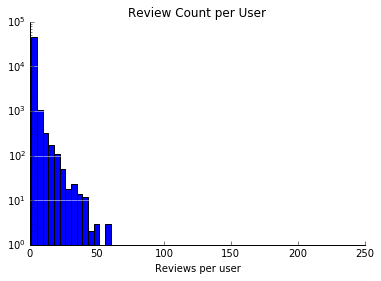

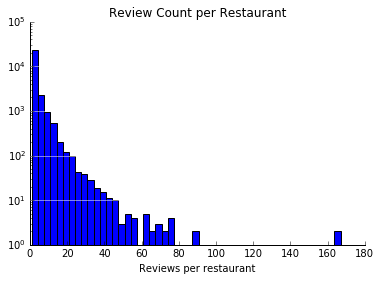

In [39]:
urc=df_rest_all.groupby('user_id').review_id.count()
ax=urc.hist(bins=50, log=True)
remove_border(ax)
plt.xlabel("Reviews per user")
plt.grid(False)
plt.grid(axis = 'y', color ='white', linestyle='-')
plt.title("Review Count per User");
plt.figure()

brc=df_rest_all.groupby('business_id').review_id.count()
ax=brc.hist(bins=50, log=True)
remove_border(ax)
plt.xlabel("Reviews per restaurant")
plt.grid(False)
plt.grid(axis = 'y', color ='white', linestyle='-')
plt.title("Review Count per Restaurant");
plt.figure()

Because many users did not have a lot of reviews, we decided to take a subset of the data in which we only looked at users who had given at least 10 reviews so that the user would exist in the train, test, and validation set.

### Reconciliation

In [40]:
# trimming the dataframe to only include reviews from users who have at least 10 restaurant reviews in our random sample
usr_rvw_appearances = df_rest_all['user_id'].value_counts()
df_rest= df_rest_all[df_rest_all['user_id'].isin(usr_rvw_appearances[usr_rvw_appearances>=10].index)]

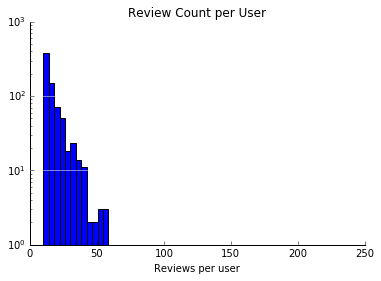

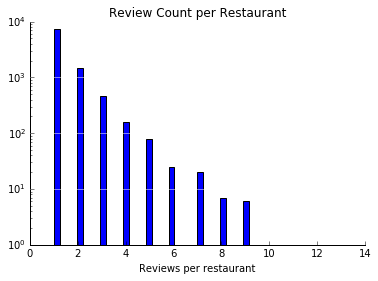

In [41]:
urc=df_rest.groupby('user_id').review_id.count()
ax=urc.hist(bins=50, log=True)
remove_border(ax)
plt.xlabel("Reviews per user")
plt.grid(False)
plt.grid(axis = 'y', color ='white', linestyle='-')
plt.title("Review Count per User");
plt.figure()

brc=df_rest.groupby('business_id').review_id.count()
ax=brc.hist(bins=50, log=True)
remove_border(ax)
plt.xlabel("Reviews per restaurant")
plt.grid(False)
plt.grid(axis = 'y', color ='white', linestyle='-')
plt.title("Review Count per Restaurant");
plt.figure()

After doing this, the distribution of the users and restaurants has fewer outliers although it is still skewed to the right.

We also noticed that a lot of restaurant who had a small amount of reviews. Thus, later on in our analysis we had to restrict the restaurants we looked at in the test and validation set according to whether or not the restaurant was present in the train set. 

### Star Ratings Distribution

3.7242261570282515


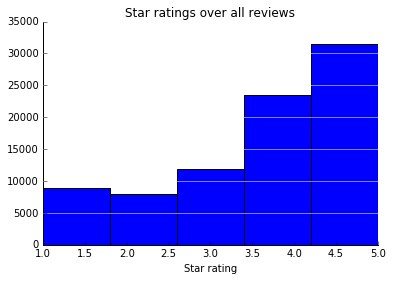

In [42]:
print(np.mean(df_rest_all['stars_rvw']))
stars=df_rest_all.stars_rvw
ax=stars.hist(bins=5)
remove_border(ax)
plt.xlabel("Star rating")
plt.grid(False)
plt.grid(axis = 'y', color ='white', linestyle='-')
plt.title("Star ratings over all reviews");

### Average Reviews

3.654464695971818


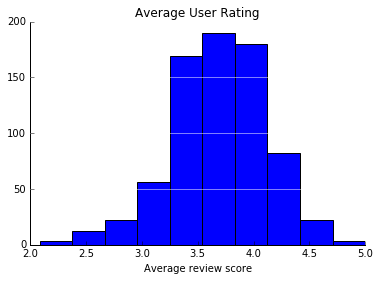

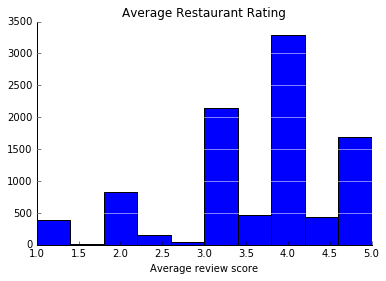

In [43]:
plt.figure()
avg_ratings_by_user=df_rest.groupby('user_id').stars_rvw.mean()
ax=avg_ratings_by_user.hist()
remove_border(ax)
plt.xlabel("Average review score")
plt.grid(False)
plt.grid(axis = 'y', color ='white', linestyle='-')
plt.title("Average User Rating")
plt.figure()

avg_ratings_by_biz=df_rest.groupby('business_id').stars_rvw.mean()
ax=avg_ratings_by_biz.hist()
remove_border(ax)
plt.xlabel("Average review score")
plt.grid(False)
plt.grid(axis = 'y', color ='white', linestyle='-')
plt.title("Average Restaurant Rating")
plt.figure()

print(df_rest.stars_rvw.mean())
plt.figure()